In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import math 
import time
import statistics
import random

In [2]:
def display_img_arr(img_arr, r, c, dim,titles_arr):
    fl = 0
    fig = plt.figure(figsize = dim)
    for i in range(r):
        for j in range(c):
            if len(img_arr) == fl:
                break
            ax1 = fig.add_subplot(r, c, fl + 1)
            ax1.set_title(titles_arr[fl], fontsize = 20)
            ax1.imshow(img_arr[fl], cmap = 'gray')
            fl = fl + 1
    plt.show()

In [3]:
def check_d(slice_ar, s):
    bool_val = False
    if np.logical_and(slice_ar,s).any():
        bool_val = True
    return bool_val
    

def erosion(image, w_size):
    m,n = image.shape
    len_padding = math.floor(win_size/2)
    padded_image = np.zeros([m+2*len_padding, n+2*len_padding])
    padded_image[len_padding:len_padding+m,len_padding:len_padding+n] = image

    
    s =  cv2.getStructuringElement(cv2.MORPH_ELLIPSE,((w_size, w_size)))
    
    rowh = padded_image.shape[0] - len_padding
    colh = padded_image.shape[1] - len_padding
    res = np.zeros(padded_image.shape)
    
    for i in range(len_padding, rowh):
        for j in range(len_padding, colh):
            slice_ar = padded_image[i-len_padding:i+len_padding+1,j-len_padding:j+len_padding+1]
            check=np.logical_and(slice_ar,s)
            if(np.array_equal(check,s)):
                res[i][j] = 1
    return res

def dilation(image, w_size):
    m,n = image.shape
    len_padding = math.floor(win_size/2)
    padded_image = np.zeros([m+2*len_padding, n+2*len_padding])
    padded_image[len_padding:len_padding+m,len_padding:len_padding+n] = image

    
    s =  cv2.getStructuringElement(cv2.MORPH_ELLIPSE,((w_size, w_size)))

    res = np.zeros(padded_image.shape)
    rowh = padded_image.shape[0] - len_padding
    colh = padded_image.shape[1] - len_padding
    for i in range(len_padding,rowh ):
        for j in range(len_padding, colh):
            slice_ar = padded_image[i-len_padding:i+len_padding+1,j-len_padding:j+len_padding+1]
            flag = check_d(slice_ar, s)
            if flag==True:
                res[i][j] = 1
    return res


def opening(image, w_size):
    return dilation(erosion(image,w_size),w_size)


def closing(image, w_size):
    return erosion(dilation(image,w_size),w_size)

In [4]:
def LaberOrdering(image):
    result_img = np.zeros(image.shape)
    ord_ = {}
    n = image.shape[0]
    m = image.shape[1]
    uniques = np.unique(image)
    for i in range(len(uniques)):
        ord_[uniques[i]] = i
    
    for i in range(n):
        for j in range(m):
            result_img[i][j] = ord_[image[i][j]]
    
    return result_img

def one_th_Pass(image, len_padding):
    result_img = np.zeros(image.shape)
    count = 0 
    parent_lst = {0:0} 
    rowh = image.shape[0] - len_padding
    colh = image.shape[1] - len_padding
    for i in range(len_padding, rowh):
        for j in range(len_padding, colh):
            neighbours = []
            cur = 0
            if image[i][j]:
                
                if result_img[i][j-1]:
                    neighbours.append(result_img[i][j-1])

                if result_img[i-1][j]:
                    neighbours.append(result_img[i-1][j])
                
                if len(neighbours) == 0:
                    count = count + 1
                    cur = count
               
                elif result_img[i][j-1] == result_img[i-1][j] :
                    tmp = neighbours[0]
                    cur = neighbours[0]
               
                else:
                    
                    for k in range(len(neighbours)):
                        neighbour = neighbours[k]
                        if neighbour in parent_lst and parent_lst[neighbour] < min(neighbours):
                            parent_lst[neighbour] = parent_lst[neighbour]
                        else:
                            parent_lst[neighbour] = min(neighbours)
                    cur = min(neighbours)
                    
                result_img[i][j] = cur
    return result_img, parent_lst


def connected_component(image, window_size):
    m,n = image.shape
    len_padding = window_size//2
    first, parent_lst = one_th_Pass(image, len_padding)
    second = np.zeros(first.shape)
    rowh = m - len_padding
    colh = n - len_padding
    for i in range(len_padding, rowh ):
            for j in range(len_padding, colh):
                child = first[i][j]
                while parent_lst[child] != child and child in parent_lst:
                    child = parent_lst[child]
                second[i][j] = child
    return LaberOrdering(second)[len_padding:m-len_padding,len_padding:n-len_padding]




In [6]:

image = cv2.imread('../images/kidney.jpg', 0)

win_size = 5

m,n = image.shape
len_padding = math.floor(win_size/2)
padded_image = np.zeros([m+2*len_padding, n+2*len_padding])
padded_image[len_padding:len_padding+m,len_padding:len_padding+n] = image


new_img = np.copy(padded_image)
new_img = np.where(new_img >= 130, 1, 0)
for i in range(3):
    new_img = erosion(new_img, win_size)
for i in range(3):
    new_img = dilation(new_img, win_size)

new_img = connected_component(new_img, win_size).astype('uint8')

In [7]:
def colourise(image):
    h = image.shape[0]
    w = image.shape[1]
    colors = []
    for i in range(300):
        colors.append([random.randint(0,255),random.randint(0,255),random.randint(0,255)])
    
    new_image = np.zeros((h, w, 3))
    for i in range(h):
        for j in range(w):
            if  image[i][j]:
                new_image[i][j] = colors[image[i][j]]
            
    new_image = new_image.astype(np.uint8)
    return new_image

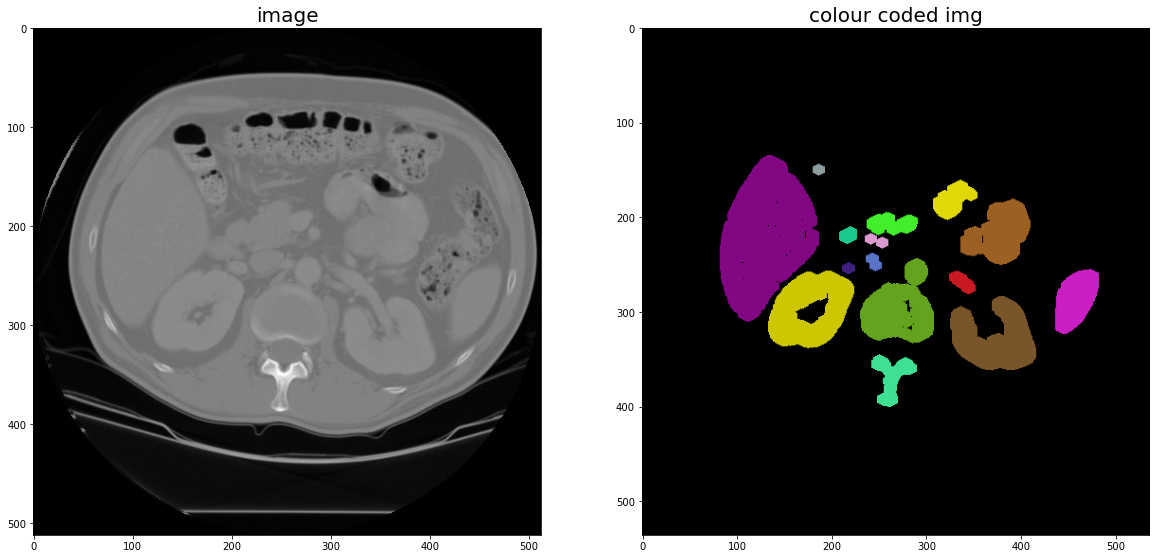

In [8]:
segmented_img = colourise(new_img)
display_img_arr([image,segmented_img], 1, 2, (20, 20), ['image','colour coded img'])
